<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic15/4_PyTorch_Build_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

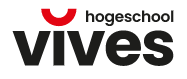<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



**PYTORCH TUTORIAL**

Deze tutorial is overgenomen van de PyTorch website:

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

# Build the Neural Network

Neural networks comprise of layers/modules that perform operations on data.
The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to
build your own neural network. Every module in PyTorch subclasses the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.


In [1]:
%matplotlib inline

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the CPU.
Recall that switching from CPU to GPU in Google Colab is done via menu "Runtime > Change runtime type".



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


[CUDA](https://en.wikipedia.org/wiki/CUDA) or Compute Unified Device Architecture is a NVIDIA's parallel computing platform and application programming interface (API) that allows software to use certain types of graphics processing units (GPUs) for general purpose processing. CUDA is a software layer that gives direct access to the GPU's virtual instruction set and parallel computational elements, for the execution of compute kernels.

## Define the Class
We define our neural network by subclassing ``nn.Module``, and
initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.



In [4]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # input layer
            nn.ReLU(),  # ReLU activation
            nn.Linear(512, 512),  # hidden layer
            nn.ReLU(),  # ReLU activation
            nn.Linear(512, 10),  # output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

The model is a `Sequential` neural net consisting of three layers:
1. an input layer with 512 units and ReLU as activation;
2. a hidden layer with 512 units and ReLU as activation;
3. an output layers with 10 units corresponding to the 10 classes.

Note that there is no softmax function defined yet for the output layer, so it returns the logits. The softmax function is applied to these logits (see below).

Check the following link if you do not know what **logits** are:

https://developers.google.com/machine-learning/glossary/#logits

Summarizing, logits are input to the softmax function to get the predicted probabilities:

logits --> softmax --> probabilities

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.



In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model's ``forward``,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
**Do not call** ``model.forward()`` **directly!**

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output.
We get the prediction probabilities by passing it through an instance of the ``nn.Softmax`` module.



In [6]:
X = torch.rand(1, 28, 28, device=device)  # random image is created
logits = model(X)  # logits are the non-normalized outputs of the model
pred_probab = nn.Softmax(dim=1)(logits)  # softmax maps logits to probabilities
y_pred = pred_probab.argmax(dim=1)  # argmax is used to get the predicted class
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2], device='cuda:0')


--------------




## Model Layers

Let's break down the layers in the FashionMNIST model. To illustrate it, we
will take a sample minibatch of 3 images of size 28x28 and see what happens to it as
we pass it through the network.



In [7]:
input_image = torch.rand(3,28,28)  # 3 random images
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten
We initialize the [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (
the minibatch dimension (at dim=0) is maintained).



In [8]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear
The [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its stored weights and biases.




In [9]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU
Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our
linear layers, but there's other activations to introduce non-linearity in your model.



In [10]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.0471,  0.1241, -0.1090, -0.0890,  0.2457,  0.1684,  0.1209,  0.2140,
          0.0814, -0.3652, -0.8356,  0.1932, -0.2312, -0.0851,  0.3873,  0.3398,
         -0.4955,  0.1351, -0.2196, -0.0646],
        [-0.0400,  0.1118, -0.1377, -0.3662,  0.1742,  0.1021,  0.4724, -0.0067,
          0.1758, -0.1554, -0.4428,  0.2843, -0.3764, -0.0797, -0.0557, -0.1149,
          0.0743,  0.2035, -0.1132, -0.0049],
        [-0.0190, -0.2186, -0.2582, -0.0518,  0.4294,  0.3451,  0.5609,  0.3431,
          0.3268, -0.2942, -0.2708,  0.2135, -0.1115, -0.0936, -0.0585,  0.2580,
         -0.1477,  0.1293, -0.1221,  0.0348]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0471, 0.1241, 0.0000, 0.0000, 0.2457, 0.1684, 0.1209, 0.2140, 0.0814,
         0.0000, 0.0000, 0.1932, 0.0000, 0.0000, 0.3873, 0.3398, 0.0000, 0.1351,
         0.0000, 0.0000],
        [0.0000, 0.1118, 0.0000, 0.0000, 0.1742, 0.1021, 0.4724, 0.0000, 0.1758,
         0.0000, 0.0000, 0.2843, 0.0000, 0.0000, 0.00

We see the ReLU function does not alter the positive values in `hidden1`, while the negative values are set to zero.

### nn.Sequential
[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like ``seq_modules``.



In [14]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
logits

tensor([[-0.0648, -0.1159,  0.0819,  0.0738, -0.1088, -0.0089,  0.0544,  0.1554,
          0.2887,  0.0883],
        [-0.0369, -0.0798,  0.0931, -0.0684, -0.2108, -0.1878,  0.1317,  0.1601,
          0.1691, -0.0180],
        [ 0.0313, -0.0944,  0.1113, -0.0046, -0.1025, -0.0904,  0.0049,  0.1462,
          0.2318, -0.1219]], grad_fn=<AddmmBackward0>)

### nn.Softmax
The last linear layer of the neural network returns `logits` - raw values in $[-\infty, \infty]$ - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values
$[0, 1]$ representing the model's predicted probabilities for each class. ``dim`` parameter indicates the dimension along
which the values must sum to 1.



In [15]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
pred_probab

tensor([[0.0890, 0.0846, 0.1031, 0.1023, 0.0852, 0.0941, 0.1003, 0.1109, 0.1268,
         0.1037],
        [0.0960, 0.0920, 0.1093, 0.0930, 0.0807, 0.0826, 0.1136, 0.1169, 0.1180,
         0.0978],
        [0.1014, 0.0894, 0.1098, 0.0978, 0.0887, 0.0898, 0.0987, 0.1137, 0.1239,
         0.0870]], grad_fn=<SoftmaxBackward0>)

In [17]:
pred_probab.sum(dim=1)  # equivalent to sum(axis=1) in numpy

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

## Model Parameters
Many layers inside a neural network are *parameterized*, i.e. have associated weights
and biases that are optimized during training. Subclassing ``nn.Module`` automatically
tracks all fields defined inside your model object, and makes all parameters
accessible using your model's ``parameters()`` or ``named_parameters()`` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.




In [18]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0251, -0.0313,  0.0029,  ...,  0.0097, -0.0079, -0.0299],
        [-0.0169, -0.0354,  0.0265,  ..., -0.0052, -0.0063, -0.0287]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0275,  0.0027], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-2.1650e-03,  3.9843e-02, -2.2657e-02,  ..., -1.2308e-02,
         -7.0168e-03,  3.2991e-02],
        [ 9.4294e-03, -2.1428e-03, -3.7663e-02,  ..., -2.6293e-02,
      

--------------




## Further Reading
- [torch.nn API](https://pytorch.org/docs/stable/nn.html)



---